In this task, we will learn how to find the hyperparameters in a neural network setting. We will use MNIST dataset, which is a handwritten digit recognition dataset. More on MNIST: http://yann.lecun.com/exdb/mnist/


## **Set Up**


###**Imports**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
from keras.datasets import mnist
import pandas as pd
import numpy as np
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense 
from keras.models import Sequential 
from numpy.random import seed
from keras.layers import Dropout
from keras import initializers

###**mount our drive and define: save() and load()**

In [78]:
#this is so we can save our ACCs and reload them later
from google.colab import drive
drive.mount('/content/drive')

def save(fileName, data):
  %cd /content/drive/MyDrive/'1 BS in CS'/'Semester 5 (Fall 2021)'/'3337 Data Science'/'Task 3'
  np.savetxt(fileName, data, delimiter=',', fmt='% s')
  !ls
def load(filename):
  %cd /content/drive/MyDrive/'1 BS in CS'/'Semester 5 (Fall 2021)'/'3337 Data Science'/'Task 3'
  return np.genfromtxt(filename, delimiter=',')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Loading raw data and preprocessing**


MNIST handwritten digit recognition dataset

if from keras.utils import to_categorical does not work, use from tensorflow.keras.utils import to_categorical

In [3]:
#Fortunately Keras already have this dataset on its server. Let's load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_test.shape

(10000, 28, 28)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.20, random_state=3037)
# DONOT change the random_state variable

In [8]:
x_train.shape

(48000, 28, 28)

In [9]:
x_valid.shape

(12000, 28, 28)

In [10]:
d = pd.DataFrame()
d["y"] = y_train

In [11]:
# Let's analyze, how the distribution for the class variable looks like:
d.y.value_counts()

1    5381
7    5004
3    4876
2    4797
0    4785
9    4774
6    4743
4    4671
8    4610
5    4359
Name: y, dtype: int64

The images we have are in the 28 * 28 dimension. For a simple shallow neural network, we donot have to consider the height and width of the images separately. That means, we can simply make a long vector of 28 * 28 = 784 dimension and work with it.

In [12]:
# Flattening the images
flattened_image = x_train.shape[1]*x_train.shape[2]
x_train = x_train.reshape(x_train.shape[0], flattened_image)
x_valid = x_valid.reshape(x_valid.shape[0], flattened_image)
x_test = x_test.reshape(x_test.shape[0], flattened_image)

In [13]:
x_train.shape

(48000, 784)

In [14]:
x_valid.shape

(12000, 784)

In [15]:
x_test.shape

(10000, 784)

In [16]:
# converting the classes to categorical variable
classes = np.unique(y_train)
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [17]:
num_classes = len(classes)
num_classes

10

For the specific loss function we will use "categorical cross entropy", it is important to convert the target class in an one-hot-encoded form

In [18]:
y_train = to_categorical(y_train)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

###**Function Definitions**

In [20]:
# # Helper function 1: 
# #create the neural network
# def create_model(num_layers, num_units, flattened_size, activation_function, class_size):
#   '''
#   We create a neural network in this function. You can choose the layer size, the units perlayer, activation function,
#   and size of the class. This function creates the basic architecture required to handle the tasks.
#   '''

#   model = Sequential()
#   model.add(Dense(units=num_units, activation=activation_function, input_shape=(flattened_size,)))
#   for i in range(num_layers-1):
#     model.add(Dense(units=num_units, activation=activation_function))
#   model.add(Dense(units=num_classes, activation='softmax'))

#   return model

# Helper function 1: 

#create the neural network

def create_model(num_layers, num_units, flattened_size, activation_function, class_size):
  '''
  We create a neural network in this function. You can choose the layer size, the units perlayer, activation function,
  and size of the class. This function creates the basic architecture required to handle the tasks.
  '''
  seed(37)
  random.seed(37)
  tf.random.set_seed(37)
  model = Sequential()
  model.add(Dense(units=num_units, activation=activation_function, input_shape=(flattened_size,)))
  for i in range(num_layers-1):
    model.add(Dense(units=num_units, activation=activation_function))
  model.add(Dense(units=num_classes, activation='softmax'))
  return model

In [21]:
def evaluate(FCmodel, Learning_Rate, batch_sz, epochs, add_visualization=True):
  '''
  This function will run and evaluate the neural network. 
  *** Important: DoNOT change the seed values. This will ensure the reproducibility of the experiments.
  '''
  seed(37)
  random.seed(37)
  tf.random.set_seed(37)
  opt = tf.keras.optimizers.SGD(learning_rate=Learning_Rate)
  FCmodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  history = FCmodel.fit(x_train, y_train, batch_size=int(batch_sz), epochs=int(epochs), 
                        verbose=add_visualization, validation_data=(x_valid, y_valid))
  loss, accuracy  = FCmodel.evaluate(x_valid, y_valid, verbose=False)

  if add_visualization:
    print(f'validation loss: {loss:.4}')
    print(f'validation accuracy: {accuracy:.4}')

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model performance')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()


  return loss, accuracy

###**Creating a model and evaluating it**

Let's check, how our model performs. Run the followung cell and make sure you get the EXACT same values as output.



Epoch 1/100
188/188 [==============================] - 1s 4ms/step - loss: 2.3016 - accuracy: 0.1125 - val_loss: 2.2961 - val_accuracy: 0.1134
Epoch 2/100
188/188 [==============================] - 1s 4ms/step - loss: 2.2937 - accuracy: 0.1166 - val_loss: 2.2904 - val_accuracy: 0.1134
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 2.2857 - accuracy: 0.1291 - val_loss: 2.2797 - val_accuracy: 0.1205
Epoch 4/100
188/188 [==============================] - 1s 3ms/step - loss: 2.2671 - accuracy: 0.1864 - val_loss: 2.2490 - val_accuracy: 0.2005
Epoch 5/100
188/188 [==============================] - 1s 3ms/step - loss: 2.2058 - accuracy: 0.2234 - val_loss: 2.1411 - val_accuracy: 0.2479
Epoch 6/100
188/188 [==============================] - 1s 4ms/step - loss: 2.0349 - accuracy: 0.2330 - val_loss: 1.9296 - val_accuracy: 0.2531
Epoch 7/100
188/188 [==============================] - 1s 3ms/step - loss: 1.8570 - accuracy: 0.2750 - val_loss: 1.8101 - val_accuracy: 0.3095

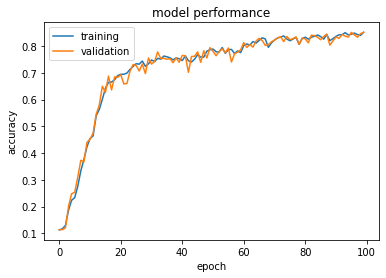

In [22]:
special_model = create_model(num_layers=4, num_units=16, flattened_size=x_test.shape[1], 
                     activation_function='sigmoid', class_size=num_classes)
loss, acc = evaluate(FCmodel=special_model, Learning_Rate=0.1, batch_sz=256, epochs=100)

In [23]:
special_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                170       
Total params: 13,546
Trainable params: 13,546
Non-trainable params: 0
_________________________________________________________________


##**Subtask 1** 
Tune each class of Hyperparameters and observe the performance with a graph.

The first one is done for you

In [ ]:
# Below are the five classes of hyperparameters
LAYERS = [2, 3, 4]
UNITS = [4, 8, 16, 32, 64, 128, 256]
BATCH = [8, 16, 32, 64, 128]
LEARNING_RATE = [0.1, 0.01, 0.001, 0.0001, 0.00001]
EPOCHS = [10, 20, 30, 40, 100]

### **Question 1**
create a Layer-vs-accuracy graph for the following setting:

units = [32, 128]

Batch_size = [16, 64]

Learning_rate = [0.1]

Epochs = [10, 20]


That means there will be 2 * 2 * 1 * 2 = 8 graphs

In [ ]:
# Question 1
# This codeblock produces and evaluates each model, and saves the qxACCs
%%time
q1ACCs = []
for B in [16, 64]:
  for E in [10,20]:
    for U in [32, 128]:
      ACC = []
      for L in LAYERS:
        special_model = create_model(num_layers=L, num_units=U, flattened_size=x_test.shape[1], 
                            activation_function='sigmoid', class_size=num_classes)
        loss, acc = evaluate(FCmodel=special_model, Learning_Rate=0.1, batch_sz=B, epochs=E, add_visualization=False)
        ACC.append(acc) 
      q1ACCs.append(ACC)
save("q1ACCs.csv",q1ACCs)

3337_Task3.ipynb  q1ACCs.csv  q4ACCs.csv  q5ACCs.csv  sub1.gdoc  Task3.gdoc
CPU times: user 22min 7s, sys: 1min 39s, total: 23min 47s
Wall time: 21min 42s


In [ ]:
#if you already ran the above block and just want to retrieve the q1ACCs, run this block
q1ACCs = load("q1ACCs.csv")

/content/drive/MyDrive/1 BS in CS/Semester 5 (Fall 2021)/3337 Data Science/Task 3
/content/drive/MyDrive/1 BS in CS/Semester 5 (Fall 2021)/3337 Data Science/Task 3


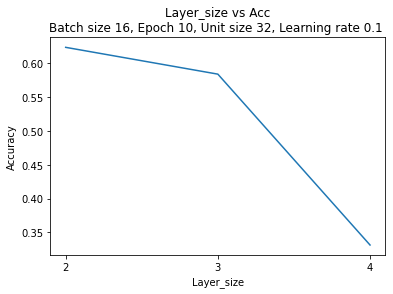

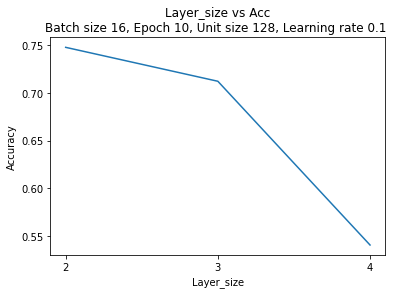

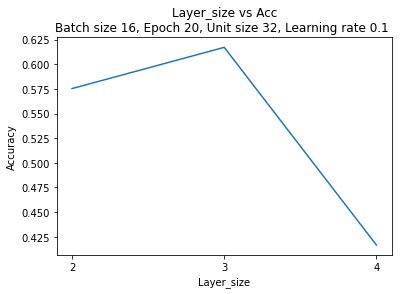

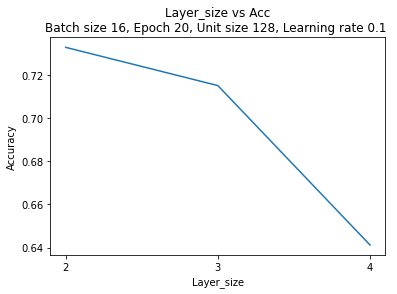

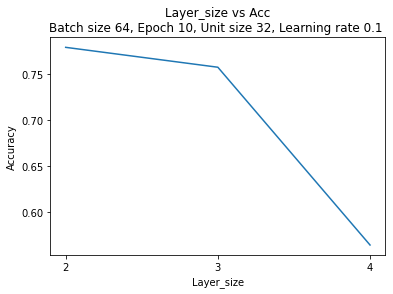

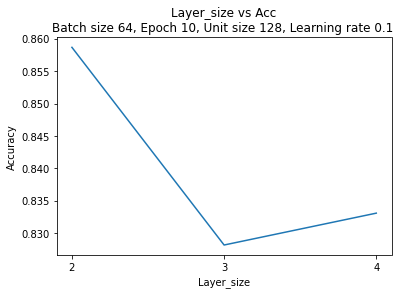

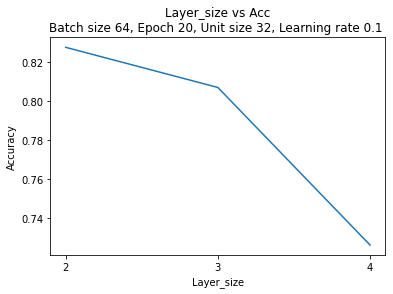

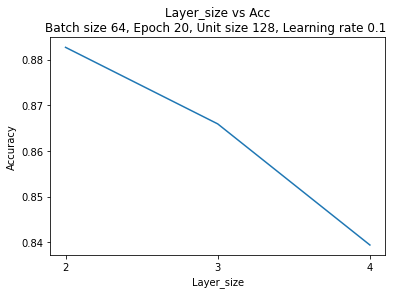

In [ ]:
# Question 1
#This codeblock only produces the graphs
i = 0
for B in [16, 64]:
  for E in [10,20]:
    for U in [32, 128]:
      plt.plot(LAYERS, q1ACCs[i])
      plt.xticks(LAYERS)
      plt.xlabel("Layer_size")
      plt.ylabel("Accuracy")
      TITLE = "Layer_size vs Acc\nBatch size {}, Epoch {}, Unit size {}, Learning rate 0.1 ".format(B, E, U)
      plt.title(TITLE)
      plt.show()
      i += 1

###**Question 2**
Create a Unit size-vs-accuracy graph for the following settings:
 
Layer size = [2]

Batch_size = [16, 64]

Learning_rate = [0.1]

Epochs = [10, 20]


That means there will be 1 * 2 * 1 * 2 = 4 graphs


In [ ]:
# Question 2
# This codeblock produces and evaluates each model, and saves the qxACCs
%%time
q2ACCs=[]
for B in [16,64]:
  for E in [10,20]:
    ACC = []
    for U in UNITS:
      special_model = create_model(num_layers=2, num_units=U, flattened_size=x_test.shape[1],
                                   activation_function='sigmoid', class_size=num_classes)
      loss, acc = evaluate(FCmodel=special_model, Learning_Rate=0.1, batch_sz=B, epochs=E, add_visualization=False)
      ACC.append(acc)
    q2ACCs.append(ACC)
save("q2ACCs.csv",q2ACCs)


3337_Task3.ipynb  q2ACCs.csv  q5ACCs.csv  Task3.gdoc
q1ACCs.csv	  q4ACCs.csv  sub1.gdoc
CPU times: user 25min 23s, sys: 2min 5s, total: 27min 29s
Wall time: 22min 45s


In [ ]:
#if you already ran the above block and just want to retrieve the q2ACCs, run this block
q2ACCs = load("q2ACCs.csv")

/content/drive/MyDrive/1 BS in CS/Semester 5 (Fall 2021)/3337 Data Science/Task 3
/content/drive/MyDrive/1 BS in CS/Semester 5 (Fall 2021)/3337 Data Science/Task 3


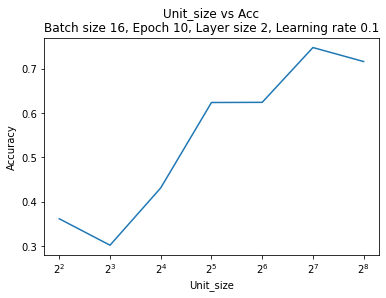

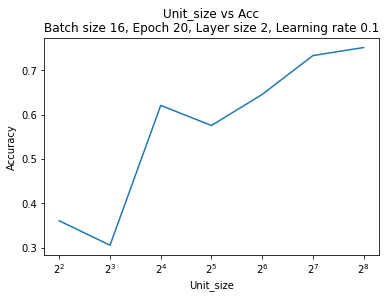

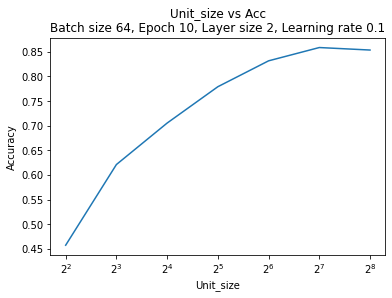

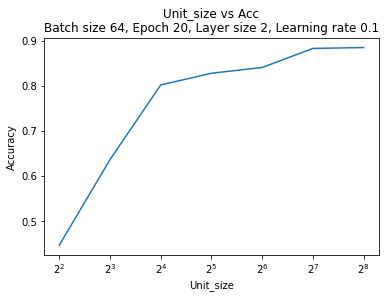

In [ ]:
# Question 2
#This codeblock only produces the graphs
i = 0
for B in [16,64]:
  for E in [10,20]:
    plt.plot(UNITS, q2ACCs[i])
    plt.xscale("log", basex=2)
    plt.xticks(UNITS)
    plt.xlabel("Unit_size")
    plt.ylabel("Accuracy")
    TITLE = "Unit_size vs Acc\nBatch size {}, Epoch {}, Layer size 2, Learning rate 0.1".format(B, E)
    plt.title(TITLE)
    plt.show()
    i += 1

###**Question 3**
create a Batch size-vs-accuracy graph for the following setting:

Layer size = [2]

Unit_size = [16, 32]

Learning_rate = [0.1]

Epochs = [10, 20]


That means there will be 1 * 2 * 1 * 2 = 4 graphs

In [ ]:
# Question 3: 
# This codeblock produces and evaluates each model, and saves the qxACCs
%%time
q3ACCs = []
for U in [16,32]:
  for E in [10,20]:
    ACC = []
    for B in BATCH:
      special_model = create_model(num_layers=2, num_units=U, flattened_size=x_test.shape[1], 
                            activation_function='sigmoid', class_size=num_classes)
      loss, acc = evaluate(FCmodel=special_model, Learning_Rate=0.1, batch_sz=B, epochs=E, add_visualization=False)
      ACC.append(acc)
    q3ACCs.append(ACC)
save("q3ACCs.csv",q3ACCs)

3337_Task3.ipynb  q2ACCs.csv  q4ACCs.csv  sub1.gdoc
q1ACCs.csv	  q3ACCs.csv  q5ACCs.csv  Task3.gdoc
CPU times: user 16min 52s, sys: 1min 21s, total: 18min 14s
Wall time: 14min 44s


In [ ]:
#if you already ran the above block and just want to retrieve the q3ACCs, run this block
q3ACCs = load("q3ACCs.csv")

/content/drive/MyDrive/1 BS in CS/Semester 5 (Fall 2021)/3337 Data Science/Task 3
/content/drive/MyDrive/1 BS in CS/Semester 5 (Fall 2021)/3337 Data Science/Task 3


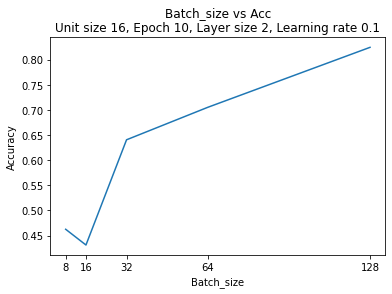

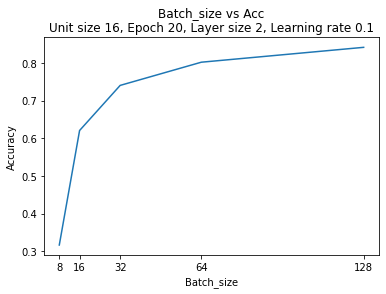

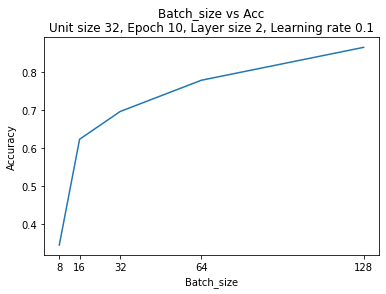

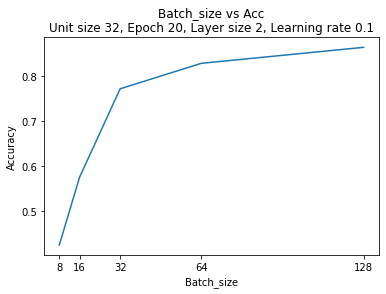

In [ ]:
# Question 3
# This codeblock only produces the graphs
i = 0
for U in [16,32]:
  for E in [10,20]:
    plt.plot(BATCH, q3ACCs[i])
    plt.xticks(BATCH)
    plt.xlabel("Batch_size")
    plt.ylabel("Accuracy")
    TITLE = "Batch_size vs Acc\nUnit size {}, Epoch {}, Layer size 2, Learning rate 0.1".format(U, E)
    plt.title(TITLE)
    plt.show()
    i += 1

###**Question 4**
create a Learning rate-vs-accuracy graph for the following setting:

Layer size = [2]

Unit_size = [16, 32]

Batch_size = [16]

Epochs = [10, 20]

That means there will be 1 * 2 * 1 * 2 = 4 graphs

In [ ]:
# Question 4
# This codeblock produces and evaluates each model, and saves the qxACCs
%%time
q4ACCs = []
for U in [16,32]:
  for E in [10,20]:
    ACC = []
    for L in LEARNING_RATE:
      special_model = create_model(num_layers=2, num_units=U, flattened_size=x_test.shape[1], 
                            activation_function='sigmoid', class_size=num_classes)
      loss, acc = evaluate(FCmodel=special_model, Learning_Rate=L, batch_sz=16, epochs=E, add_visualization=False)
      ACC.append(acc)
    q4ACCs.append(ACC)
save("q4ACCs.csv",q4ACCs)

CPU times: user 21min, sys: 1min 39s, total: 22min 40s
Wall time: 18min 18s


In [ ]:
#if you already ran the above block and just want to retrieve the q4ACCs, run this block
q4ACCs = load("q4ACCs.csv")

/content/drive/MyDrive/1 BS in CS/Semester 5 (Fall 2021)/3337 Data Science/Task 3
/content/drive/MyDrive/1 BS in CS/Semester 5 (Fall 2021)/3337 Data Science/Task 3


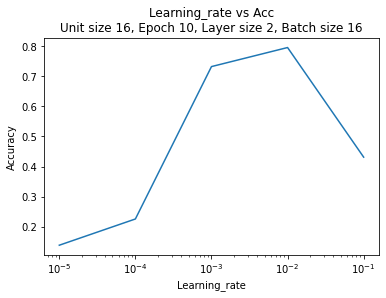

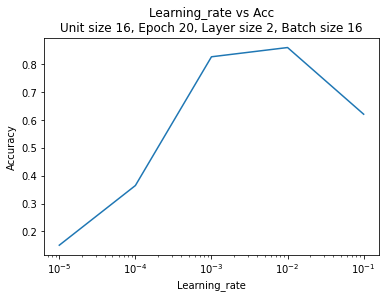

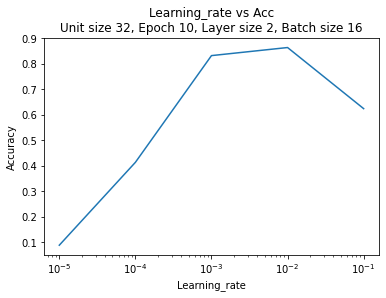

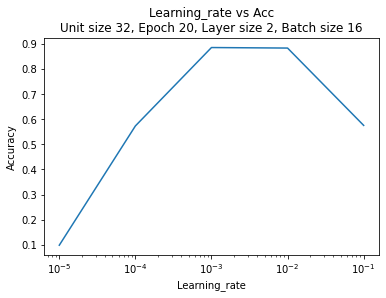

In [ ]:
# Question 4
# This codeblock only produces the graphs
i = 0
for U in [16,32]:
  for E in [10,20]:
    plt.plot(LEARNING_RATE, q4ACCs[i])
    plt.xscale('log')
    plt.xticks(LEARNING_RATE)
    plt.xlabel("Learning_rate")
    plt.ylabel("Accuracy")
    TITLE = "Learning_rate vs Acc\nUnit size {}, Epoch {}, Layer size 2, Batch size 16".format(U, E)
    plt.title(TITLE)
    plt.show()
    i += 1

###**Question 5**
create a Epoch size-vs-accuracy graph for the following setting:

Layer size = [2]

Unit_size = [32]

Batch_size = [8, 16]

Learning_rate = [0.1]

That means there will be 1 * 1 * 2 * 1 = 2 graphs


In [ ]:
# Question 5
# This codeblock produces and evaluates each model, and saves the qxACCs
q5ACCs = []
for B in [8,16]:
  ACC = []
  for E in EPOCHS:
    special_model = create_model(num_layers=2, num_units=32, flattened_size=x_test.shape[1], 
                            activation_function='sigmoid', class_size=num_classes)
    loss, acc = evaluate(FCmodel=special_model, Learning_Rate=0.1, batch_sz=B, epochs=E, add_visualization=False)
    ACC.append(acc)
  q5ACCs.append(ACC)
save("q5ACCs.csv",q5ACCs)

In [ ]:
#if you already ran the above block before and just want to retrieve the q5ACCs, run this block
q5ACCs = load("q5ACCs.csv")

/content/drive/MyDrive/1 BS in CS/Semester 5 (Fall 2021)/3337 Data Science/Task 3
/content/drive/MyDrive/1 BS in CS/Semester 5 (Fall 2021)/3337 Data Science/Task 3


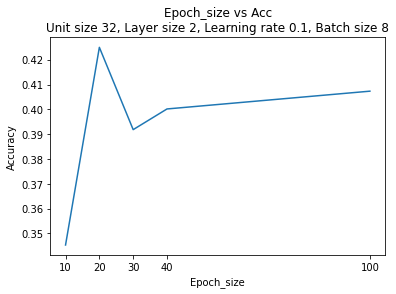

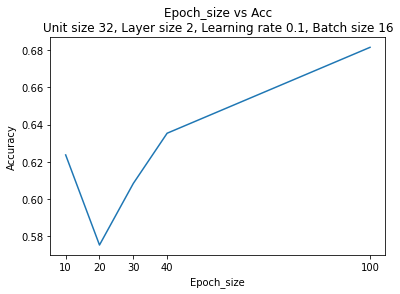

In [ ]:
# Question 5
# This codeblock only produces the graphs
i = 0
for B in [8,16]:
  plt.plot(EPOCHS, q5ACCs[i])
  plt.xticks(EPOCHS)
  plt.xlabel("Epoch_size")
  plt.ylabel("Accuracy")
  TITLE = "Epoch_size vs Acc\nUnit size 32, Layer size 2, Learning rate 0.1, Batch size {}".format(B)
  plt.title(TITLE)
  plt.show()
  i += 1

##**Subtask 2**

Grid search of hyperparameters to find the best set of hyperparameters.

Rank the best set of parameters among the following settings:

LAYERS = [2, 3, 4]

UNITS = [16, 64]

BATCH_SIZE = [8, 32, 128]

LEARNING_RATE = [0.1, 0.01, 0.001, 0.0001, 0.00001]

EPOCHS = [10, 20, 30]


Also comment the three best and three worst setting of hyperparameters

###**Function Definitions**

In [24]:
def createModelsAndEvaluate(LAYERS, UNITS, BATCH_SIZE, LEARNING_RATE, EPOCHS, num_classes):
  rows = []
  for L in LAYERS:
    for U in UNITS:
      for B in BATCH_SIZE:
        for R in LEARNING_RATE:
          for E in EPOCHS:
            model = create_model(num_layers=L, num_units=U, flattened_size=x_test.shape[1], 
                            activation_function='sigmoid', class_size=num_classes)
            loss, acc = evaluate(FCmodel=model, Learning_Rate=R, batch_sz=B, epochs=E, add_visualization=False)
            rows.append([L,U,B,R,E,acc]) 
  return rows


In [25]:
def hyperparameter_ranking(data) ->pd.DataFrame:
  '''
  Your code should return a DataFrame where columns will be LAYERS, UNITS, BATCH_SIZE, LEARNING_RATE, EPOCHS and corresponding accuracy.
  The dataframe MUST be sorted in descending order based on the accuracy like the following cell. There will be 270 row
  '''
  columnNames = ["LAYERS","UNITS","BATCH_SIZE","LEARNING_RATE", "EPOCHS","Accuracy"]
  return pd.DataFrame(data, columns = columnNames).sort_values(by="Accuracy", ascending=False, ignore_index=True)
  

###**Execution**

In [46]:
LAYERS = [2, 3, 4]
UNITS = [16, 64]
BATCH_SIZE = [8, 32, 128]
LEARNING_RATE = [0.1, 0.01, 0.001, 0.0001, 0.00001]
EPOCHS = [10, 20, 30]

In [ ]:
#this will create the models, evaluate them, and aggregate parameters and related accuracies 
#into a list called data, and then it will save the data so we can reload it later
%%time
subTask2_data = createModelsAndEvaluate(LAYERS, UNITS, BATCH_SIZE, LEARNING_RATE, EPOCHS, num_classes)
save("subTask2_data.csv", subTask2_data)

In [26]:
#if you already ran the above code before, don't rerun it, instead just load the data from the saved file
subTask2_data = load("subTask2_data.csv")

/content/drive/MyDrive/1 BS in CS/Semester 5 (Fall 2021)/3337 Data Science/Task 3


In [28]:
#this will rank (sort) the models based on their accuracies
subTask2_data = hyperparameter_ranking(subTask2_data)

In [29]:
#get first five rows from the dataframe
subTask2_data.head()

,LAYERS,UNITS,BATCH_SIZE,LEARNING_RATE,EPOCHS,Accuracy
0,2.0,64.0,8.0,0.001,30.0,0.932833
1,2.0,64.0,32.0,0.010,30.0,0.927750
2,2.0,64.0,32.0,0.010,20.0,0.923583
3,2.0,64.0,8.0,0.001,20.0,0.922917
4,2.0,64.0,128.0,0.010,30.0,0.922083


In [30]:
#get last five rows from the dataframe
subTask2_data.tail()

,LAYERS,UNITS,BATCH_SIZE,LEARNING_RATE,EPOCHS,Accuracy
265,3.0,64.0,128.0,0.00010,10.0,0.093167
266,3.0,64.0,32.0,0.00001,30.0,0.091000
267,3.0,64.0,8.0,0.00001,10.0,0.087083
268,3.0,64.0,128.0,0.00010,20.0,0.085333
269,4.0,64.0,128.0,0.00010,20.0,0.060667


In [31]:
#Also comment the three best settings of hyperparameters
subTask2_data.head(3)

,LAYERS,UNITS,BATCH_SIZE,LEARNING_RATE,EPOCHS,Accuracy
0,2.0,64.0,8.0,0.001,30.0,0.932833
1,2.0,64.0,32.0,0.010,30.0,0.927750
2,2.0,64.0,32.0,0.010,20.0,0.923583


In [32]:
#and three worst settings of hyperparameters
subTask2_data.tail(3)

,LAYERS,UNITS,BATCH_SIZE,LEARNING_RATE,EPOCHS,Accuracy
267,3.0,64.0,8.0,0.00001,10.0,0.087083
268,3.0,64.0,128.0,0.00010,20.0,0.085333
269,4.0,64.0,128.0,0.00010,20.0,0.060667


## **Subtask 3**
Advanced Hyperparameter Optimization

In this task, you have to find some advanced hyperparameters:

Optimizers = [SGD, Adam, RMSprop, Adagrad] 

[read more about Optimizers](https://keras.io/api/optimizers/)

Dropout_Rates = [0, 0.2, 0.5] 

[read more about Dropout rate](https://keras.io/api/layers/regularization_layers/dropout/)

Kernel_Initializers = [random_uniform, glorot_normal, random_normal, zeros] 

[read more about Kernel initializers](https://keras.io/api/layers/initializers/)


Special Note: You will investigate different settings for these hyperparameters as well. For example, for ADAM, there are beta_1 and beta_2 values. You can assume them to be default value (0.9 and 0.999). For other Optimizers, and kernel intializers, you can assume their default value for this subtask

Follow the steps below:

### **Step 1** 

Choose the best set of parameters from the subtask2. This will be the first entry from the dataframe table.

In [33]:
best_hyperparameters = subTask2_data.iloc[0]
best_hyperparameters

LAYERS            2.000000
UNITS            64.000000
BATCH_SIZE        8.000000
LEARNING_RATE     0.001000
EPOCHS           30.000000
Accuracy          0.932833
Name: 0, dtype: float64

###**Step 2**

Modify the function create_model by creating the new function create_model_subtask3 that additionally considers the Dropout rate, and Kernel Initializer! For dropout this can be done as follow: 

model.add..................... model.add(Dropout(0))

In [34]:
def create_model_subtask3(kernel_init, dropout_rate, flattened_size, activation_function, class_size, 
                          num_layers = best_hyperparameters["LAYERS"], num_units = best_hyperparameters["UNITS"]):
  '''
  We create a neural network in this function. You can choose the layer size, the units perlayer, activation function,
  and size of the class. This function creates the basic architecture required to handle the tasks.
  '''
  seed(37)
  random.seed(37)
  tf.random.set_seed(37)
  model = Sequential()

  if kernel_init == "random_uniform":
    initializer = initializers.random_uniform
  elif kernel_init == "glorot_normal":
    initializer = initializers.glorot_normal
  elif kernel_init == "random_normal":
    initializer = initializers.random_normal
  elif kernel_init == "zeros":
    initializer = initializers.zeros

  model.add(Dense(kernel_initializer=initializer, units=num_units, activation=activation_function, input_shape=(flattened_size,)))
  for i in range(int(num_layers)-1):
    model.add(Dense(kernel_initializer=initializer,units=num_units, activation=activation_function))
  model.add(Dense(kernel_initializer=initializer,units=num_classes, activation='softmax'))
  model.add(Dropout(rate = dropout_rate))
  return model

###**Step 3**

Modify the function evaluate to evaluate_subtask3 to account for the optimizers

In [35]:
def evaluate_subtask3(optimizerSTR, FCmodel, 
                      Learning_Rate = best_hyperparameters["LEARNING_RATE"], batch_sz = best_hyperparameters["BATCH_SIZE"], epochs = best_hyperparameters["EPOCHS"], add_visualization=True):
  '''
  This function will run and evaluate the neural network. 
  *** Important: DoNOT change the seed values. This will ensure the reproducibility of the experiments.
  '''
  seed(37)
  random.seed(37)
  tf.random.set_seed(37)

  if optimizerSTR == "SGD":
    opt = tf.keras.optimizers.SGD(learning_rate=Learning_Rate)
  elif optimizerSTR == "Adam":
    opt = tf.keras.optimizers.Adam(learning_rate=Learning_Rate)
  elif optimizerSTR == "RMSprop":
    opt = tf.keras.optimizers.RMSprop(learning_rate=Learning_Rate)
  elif optimizerSTR == "Adagrad":
    opt = tf.keras.optimizers.Adagrad(learning_rate=Learning_Rate)


  FCmodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  history = FCmodel.fit(x_train, y_train, batch_size=int(batch_sz), epochs=int(epochs), 
                        verbose=add_visualization, validation_data=(x_valid, y_valid))
  loss, accuracy  = FCmodel.evaluate(x_valid, y_valid, verbose=False)

  # if add_visualization:
  #   print(f'validation loss: {loss:.4}')
  #   print(f'validation accuracy: {accuracy:.4}')

  #   plt.plot(history.history['accuracy'])
  #   plt.plot(history.history['val_accuracy'])
  #   plt.title('model performance')
  #   plt.ylabel('accuracy')
  #   plt.xlabel('epoch')
  #   plt.legend(['training', 'validation'], loc='best')
  #   plt.show()


  return loss, accuracy

###**Step 4**


In [53]:
def createModelsAndEvaluate_subtask3(Kernel_Initializers, Dropout_Rates, Optimizers, num_classes):
  rows = []
  numModels = len(Kernel_Initializers) * len(Dropout_Rates) * len(Optimizers)
  present = 1
  for i in Kernel_Initializers:
    for d in Dropout_Rates:
      for o in Optimizers:
        model = create_model_subtask3(i, d, flattened_size=x_test.shape[1], activation_function='sigmoid', class_size=num_classes)
        loss, acc = evaluate_subtask3(optimizerSTR=o, FCmodel=model)
        rows.append([i,d,o,acc])
        print("{}/{} models done".format(present,numModels))
        present += 1 
  return rows

In [37]:
def advanced_hyperparameter_search(rows)->pd.DataFrame:
  '''
  In the same way as subtask2, create a table with columns for 
  KERNEL_INITIALIZER, DROPOUT_RATE, OPTIMIZER, and Accuracy
  The dataframe MUST be sorted in descending order based on the accuracy like the following cell. There will be 48 rows, 
  For other parameters, use the best one you found from subtask2 function hyperparameter_ranking. 
  '''
  columnNames = ["KERNEL_INITIALIZER", "DROPOUT_RATE", "OPTIMIZER", "Accuracy"]
  return pd.DataFrame(rows, columns=columnNames).sort_values(by="Accuracy", ascending=False, ignore_index=True)

###**Step 5: Execution**


In [38]:
Kernel_Initializers = ["random_uniform", "glorot_normal", "random_normal", "zeros"] 
Dropout_Rates = [0, 0.2, 0.5]
Optimizers = ["SGD", "Adam", "RMSprop", "Adagrad"]

In [ ]:
##produce all models and evaluate them
%%time
subTask3_data = createModelsAndEvaluate_subtask3(Kernel_Initializers, Dropout_Rates, Optimizers, num_classes)
save("subTask3_data_numpy.csv",subTask3_data) #just in case

In [90]:
#transmute them into a pandas dataframe and sort them, then save them
subTask3_data = advanced_hyperparameter_search(subTask3_data3)
subTask3_data.to_csv("subTask3_data.csv")

In [67]:
#if you've already run the above columns, just reload the data
columnNames = ["KERNEL_INITIALIZER", "DROPOUT_RATE", "OPTIMIZER", "Accuracy"]
subTask3_data = pd.read_csv("subTask3_data.csv", names=columnNames)

3337_Task3.ipynb   q2ACCs.csv  q5ACCs.csv  sub3.gdoc	      Task3.gdoc
data_subtask3.csv  q3ACCs.csv  sub1.gdoc   subTask2_data.csv
q1ACCs.csv	   q4ACCs.csv  sub2.gdoc   subTask3_data.csv


In [91]:
subTask3_data.head()

,KERNEL_INITIALIZER,DROPOUT_RATE,OPTIMIZER,Accuracy
0,random_normal,0,Adam,0.941417
1,glorot_normal,0,Adam,0.940083
2,glorot_normal,0,RMSprop,0.93925
3,random_uniform,0,Adam,0.937917
4,random_normal,0,RMSprop,0.93525


In [92]:
subTask3_data.tail()

,KERNEL_INITIALIZER,DROPOUT_RATE,OPTIMIZER,Accuracy
43,glorot_normal,0.5,RMSprop,0.0948333
44,glorot_normal,0.5,Adam,0.0948333
45,glorot_normal,0.5,SGD,0.0948333
46,random_uniform,0.5,RMSprop,0.0948333
47,zeros,0.5,Adagrad,0.0948333


In [93]:
subTask3_data

,KERNEL_INITIALIZER,DROPOUT_RATE,OPTIMIZER,Accuracy
0,random_normal,0,Adam,0.941417
1,glorot_normal,0,Adam,0.940083
2,glorot_normal,0,RMSprop,0.93925
3,random_uniform,0,Adam,0.937917
4,random_normal,0,RMSprop,0.93525
5,random_uniform,0.2,RMSprop,0.934417
6,random_uniform,0,RMSprop,0.932917
7,glorot_normal,0,SGD,0.931833
8,glorot_normal,0.2,RMSprop,0.931
9,random_uniform,0.2,Adam,0.930667


In [95]:
subTask3_data.query("KERNEL_INITIALIZER == 'zeros'")

,KERNEL_INITIALIZER,DROPOUT_RATE,OPTIMIZER,Accuracy
24,zeros,0.2,RMSprop,0.214
25,zeros,0,Adam,0.213583
26,zeros,0,RMSprop,0.21175
27,zeros,0,Adagrad,0.211417
28,zeros,0.2,SGD,0.209833
29,zeros,0,SGD,0.20475
30,zeros,0.2,Adagrad,0.203167
31,zeros,0.2,Adam,0.113417
32,zeros,0.5,SGD,0.0948333
33,zeros,0.5,Adam,0.0948333


In [100]:
subTask3_data.query("KERNEL_INITIALIZER != 'zeros' and DROPOUT_RATE != 0.5")

,KERNEL_INITIALIZER,DROPOUT_RATE,OPTIMIZER,Accuracy
0,random_normal,0,Adam,0.941417
1,glorot_normal,0,Adam,0.940083
2,glorot_normal,0,RMSprop,0.93925
3,random_uniform,0,Adam,0.937917
4,random_normal,0,RMSprop,0.93525
5,random_uniform,0.2,RMSprop,0.934417
6,random_uniform,0,RMSprop,0.932917
7,glorot_normal,0,SGD,0.931833
8,glorot_normal,0.2,RMSprop,0.931
9,random_uniform,0.2,Adam,0.930667
